In [56]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.16.2


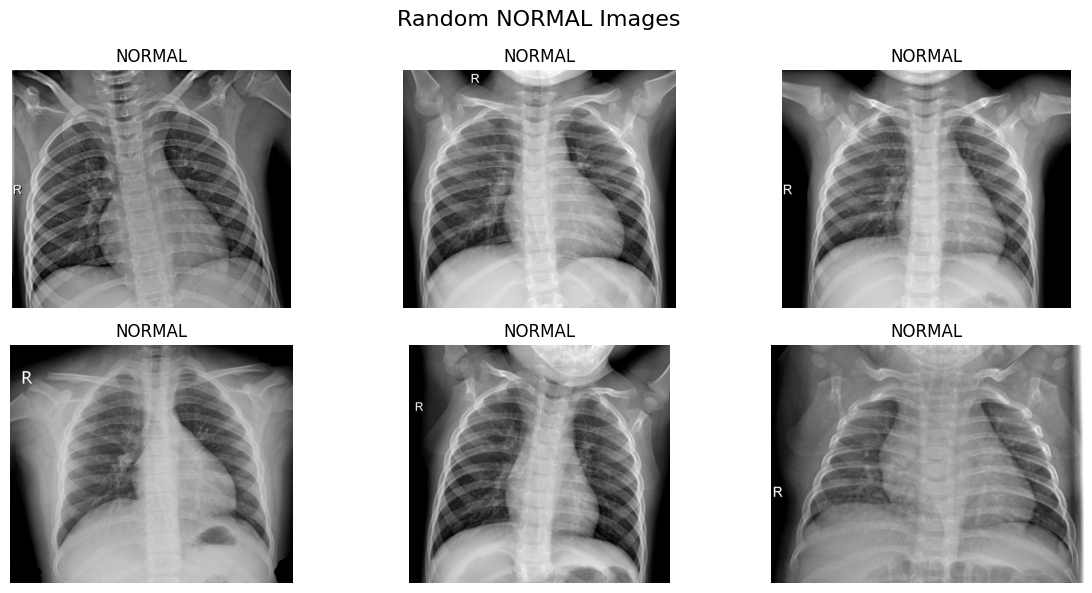

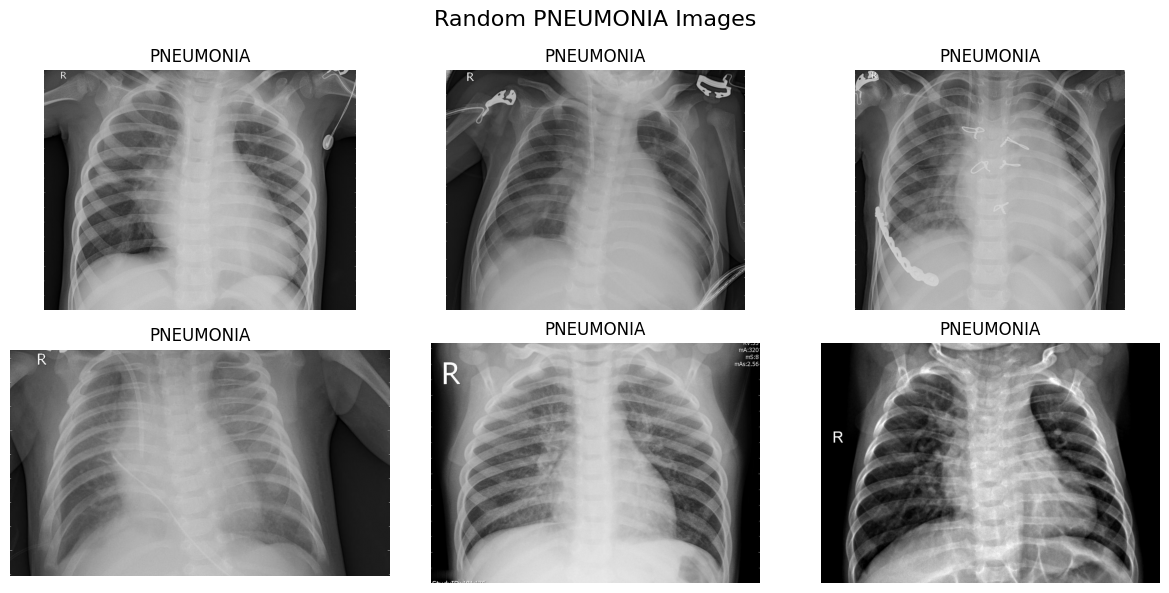

In [69]:
# Correct base directory
base_dir   = "Downloads/chest_xray/chest_xray"  

train_dir  = os.path.join(base_dir, "train")
val_dir    = os.path.join(base_dir, "val")
test_dir   = os.path.join(base_dir, "test")

# Correct paths for viewing images (INSIDE train folder)
normal_dir = os.path.join(train_dir, "NORMAL")
pneumonia_dir = os.path.join(train_dir, "PNEUMONIA")

IMG_SIZE   = (224, 224)
BATCH_SIZE = 16
EPOCHS     = 10
SEED       = 42

# Function to show random images
def show_random_images(folder, title, n=6):
    images = os.listdir(folder)
    random_imgs = random.sample(images, n)

    plt.figure(figsize=(12, 6))
    for i, img_name in enumerate(random_imgs):
        img_path = os.path.join(folder, img_name)
        img = Image.open(img_path)
        plt.subplot(2, 3, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(title)
        plt.axis('off')
    plt.suptitle(f"Random {title} Images", fontsize=16)
    plt.tight_layout()
    plt.show()

# Now this will work
show_random_images(normal_dir, "NORMAL")
show_random_images(pneumonia_dir, "PNEUMONIA")


In [71]:
# 2. DATA GENERATORS
# =========================
# Chest X-rays are technically grayscale, but we load them as RGB (3 channels)
# so they match the pretrained ImageNet models.

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # for DenseNet
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True,   # Some people disable this for X-rays; up to you
)

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    color_mode="rgb",
    shuffle=True,
    seed=SEED
)

val_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    color_mode="rgb",
    shuffle=False
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    color_mode="rgb",
    shuffle=False
)

print("Class indices:", train_gen.class_indices)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Class indices: {'NORMAL': 0, 'PNEUMONIA': 1}


In [73]:
# 3. BUILD MODEL (DenseNet121)
# =========================
# Use pretrained DenseNet121 as feature extractor
base_model = DenseNet121(
    include_top=False,
    input_shape=IMG_SIZE + (3,),
    weights="imagenet"
)

# Freeze most layers at first (transfer learning)
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.4)(x)
output = layers.Dense(1, activation="sigmoid")(x)

model = models.Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_2    │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d_2… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_3    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_3… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,300,161 (27.85 MB)

 Trainable params: 262,657 (1.00 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [75]:
# 4. CALLBACKS
# =========================
os.makedirs("models", exist_ok=True)
checkpoint_path = "models/chest_xray_densenet_best.h5"

callbacks = [
    EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True
    ),
    ModelCheckpoint(
        checkpoint_path,
        monitor="val_loss",
        save_best_only=True,
        verbose=1
    )
]

In [77]:
# =========================
# 5. TRAIN (FROZEN BASE)
# =========================
history = model.fit(
    train_gen,
    epochs=EPOCHS,
    validation_data=val_gen,
    callbacks=callbacks
)



Epoch 1/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8337 - loss: 0.3891
Epoch 1: val_loss improved from inf to 0.19699, saving model to models/chest_xray_densenet_best.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 427s 1s/step - accuracy: 0.8339 - loss: 0.3888 - val_accuracy: 0.9375 - val_loss: 0.1970
Epoch 2/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9164 - loss: 0.2069
Epoch 2: val_loss did not improve from 0.19699
326/326 ━━━━━━━━━━━━━━━━━━━━ 394s 1s/step - accuracy: 0.9164 - loss: 0.2070 - val_accuracy: 0.8750 - val_loss: 0.2458
Epoch 3/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9144 - loss: 0.2200
Epoch 3: val_loss improved from 0.19699 to 0.17868, saving model to models/chest_xray_densenet_best.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 414s 1s/step - accuracy: 0.9145 - loss: 0.2199 - val_accuracy: 0.9375 - val_loss: 0.1787
Epoch 4/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9155 - loss: 0.2020
Epoch 4: val_loss did not improve from 0.17868
326/326 ━━━━━━━━━━━━━━━━━━━━ 416s 1s/step - accuracy: 0.9155 - loss: 0.2020 - val_accuracy: 0.8750 - val_loss: 0.3034
Epoch 5/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9173 - loss: 0.2016
Epoch 5: val_loss improved from 0.17868 to 0.13790, saving model to models/chest_xray_densenet_best.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 422s 1s/step - accuracy: 0.9173 - loss: 0.2016 - val_accuracy: 0.9375 - val_loss: 0.1379
Epoch 6/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9283 - loss: 0.1740
Epoch 6: val_loss did not improve from 0.13790
326/326 ━━━━━━━━━━━━━━━━━━━━ 573s 2s/step - accuracy: 0.9283 - loss: 0.1740 - val_accuracy: 0.8750 - val_loss: 0.1800
Epoch 7/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9273 - loss: 0.1761
Epoch 7: val_loss did not improve from 0.13790
326/326 ━━━━━━━━━━━━━━━━━━━━ 415s 1s/step - accuracy: 0.9273 - loss: 0.1761 - val_accuracy: 0.8750 - val_loss: 0.2559
Epoch 8/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9304 - loss: 0.1662
Epoch 8: val_loss did not improve from 0.13790
326/326 ━━━━━━━━━━━━━━━━━━━━ 432s 1s/step - accuracy: 0.9304 - loss: 0.1663 - val_accuracy: 0.8750 - val_loss: 0.2578
Epoch 9/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9231 - loss: 0.1841
Epoch 9: val_loss did not improve from 0.13790


In [95]:
# 6. OPTIONAL: FINE-TUNING
# =========================
# Unfreeze last few layers of DenseNet for more performance
fine_tune_at = len(base_model.layers) - 40  # unfreeze last ~40 layers

for i, layer in enumerate(base_model.layers):
    layer.trainable = (i >= fine_tune_at)

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

print("Fine-tuning from layer:", fine_tune_at)

history_ft = model.fit(
    train_gen,
    epochs=10,
    validation_data=val_gen,
    callbacks=callbacks
)


Fine-tuning from layer: 387
Epoch 1/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9202 - loss: 0.2184
Epoch 1: val_loss improved from 0.13790 to 0.08577, saving model to models/chest_xray_densenet_best.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 442s 1s/step - accuracy: 0.9203 - loss: 0.2182 - val_accuracy: 1.0000 - val_loss: 0.0858
Epoch 2/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9471 - loss: 0.1311
Epoch 2: val_loss improved from 0.08577 to 0.05592, saving model to models/chest_xray_densenet_best.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 441s 1s/step - accuracy: 0.9471 - loss: 0.1311 - val_accuracy: 1.0000 - val_loss: 0.0559
Epoch 3/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9565 - loss: 0.1151
Epoch 3: val_loss improved from 0.05592 to 0.03825, saving model to models/chest_xray_densenet_best.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 426s 1s/step - accuracy: 0.9565 - loss: 0.1150 - val_accuracy: 1.0000 - val_loss: 0.0383
Epoch 4/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9660 - loss: 0.0972
Epoch 4: val_loss improved from 0.03825 to 0.03657, saving model to models/chest_xray_densenet_best.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 453s 1s/step - accuracy: 0.9660 - loss: 0.0972 - val_accuracy: 1.0000 - val_loss: 0.0366
Epoch 5/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9688 - loss: 0.0835
Epoch 5: val_loss improved from 0.03657 to 0.02303, saving model to models/chest_xray_densenet_best.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 456s 1s/step - accuracy: 0.9688 - loss: 0.0835 - val_accuracy: 1.0000 - val_loss: 0.0230
Epoch 6/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9779 - loss: 0.0555
Epoch 6: val_loss improved from 0.02303 to 0.01383, saving model to models/chest_xray_densenet_best.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 461s 1s/step - accuracy: 0.9779 - loss: 0.0555 - val_accuracy: 1.0000 - val_loss: 0.0138
Epoch 7/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9788 - loss: 0.0572
Epoch 7: val_loss did not improve from 0.01383
326/326 ━━━━━━━━━━━━━━━━━━━━ 476s 1s/step - accuracy: 0.9788 - loss: 0.0572 - val_accuracy: 1.0000 - val_loss: 0.0433
Epoch 8/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9807 - loss: 0.0528
Epoch 8: val_loss did not improve from 0.01383
326/326 ━━━━━━━━━━━━━━━━━━━━ 476s 1s/step - accuracy: 0.9807 - loss: 0.0528 - val_accuracy: 0.9375 - val_loss: 0.0867
Epoch 9/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9825 - loss: 0.0536
Epoch 9: val_loss improved from 0.01383 to 0.00885, saving model to models/chest_xray_densenet_best.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 478s 1s/step - accuracy: 0.9825 - loss: 0.0536 - val_accuracy: 1.0000 - val_loss: 0.0089
Epoch 10/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9866 - loss: 0.0408
Epoch 10: val_loss did not improve from 0.00885
326/326 ━━━━━━━━━━━━━━━━━━━━ 490s 2s/step - accuracy: 0.9866 - loss: 0.0408 - val_accuracy: 1.0000 - val_loss: 0.0309


In [97]:
# 7. EVALUATE ON TEST SET
# =========================
test_loss, test_acc = model.evaluate(test_gen)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

# Get predictions and compute additional metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

test_gen.reset()
y_prob = model.predict(test_gen).ravel()
y_pred = (y_prob > 0.5).astype(int)
y_true = test_gen.classes

print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred))

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=list(test_gen.class_indices.keys())))

try:
    auc = roc_auc_score(y_true, y_prob)
    print(f"\nROC AUC: {auc:.4f}")
except Exception as e:
    print("Could not compute AUC:", e)


39/39 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.9027 - loss: 0.3718
Test Loss: 0.2903, Test Accuracy: 0.9199
39/39 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step

Confusion Matrix:
[[200  34]
 [ 16 374]]

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.93      0.85      0.89       234
   PNEUMONIA       0.92      0.96      0.94       390

    accuracy                           0.92       624
   macro avg       0.92      0.91      0.91       624
weighted avg       0.92      0.92      0.92       624


ROC AUC: 0.9693


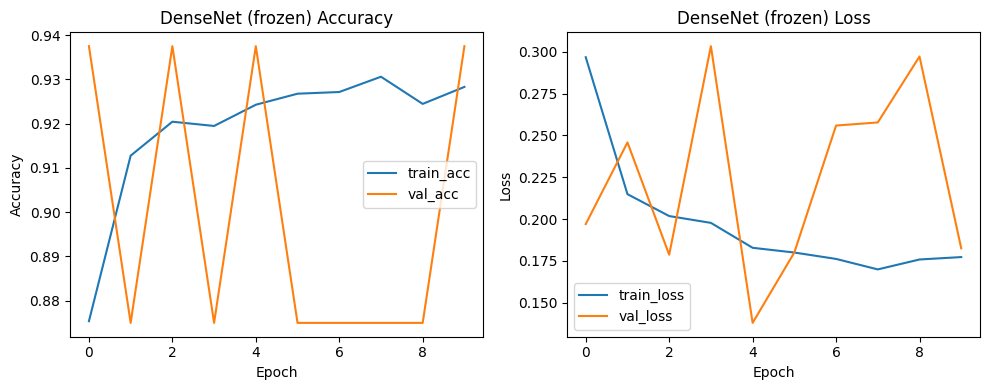

In [99]:
# 8. PLOT TRAINING CURVES
# =========================
def plot_history(hist, title=""):
    plt.figure(figsize=(10,4))
    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(hist.history["accuracy"], label="train_acc")
    plt.plot(hist.history["val_accuracy"], label="val_acc")
    plt.title(f"{title} Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    # Loss
    plt.subplot(1,2,2)
    plt.plot(hist.history["loss"], label="train_loss")
    plt.plot(hist.history["val_loss"], label="val_loss")
    plt.title(f"{title} Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history, "DenseNet (frozen)")
#plot_history(history_ft, "DenseNet (fine-tuned)")